In [1]:
from marketsai.mon_policy.env_mon_policy_finite import MonPolicyFinite

# import scipy.io as sio
# from scipy.interpolate import RegularGridInterpolator
from scipy.stats import linregress
from marketsai.utils import encode
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression


# from sklearn import linear_model
import numpy as np
import seaborn as sn
import csv
import json
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.registry import register_env
from ray import shutdown, init

""" GLOBAL CONFIGS """
# Script Options
FOR_PUBLIC = False  # for publication
SAVE_CSV = False  # save learning CSV
PLOT_HIST = True
PLOT_PROGRESS = False  # create plot with progress
SIMUL_PERIODS = 1080
ENV_HORIZON = 72
BETA = 0.95 ** (1 / 12)

# register environment
env_label = "mon_policy_finite"
register_env(env_label, MonPolicyFinite)

# Input Directories (of json file with experiment data)
INPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/expINFO_native_mon_policy_finite_2_firms_Oct18_v1_PPO_run.json"
INPUT_PATH_CHECKPOINT = "/Users/matiascovarrubias/ray_results/native_mon_policy_finite_2_firms_Oct18_v1_PPO_run/PPO_mon_policy_finite_6310c_00000_0_2021-10-18_22-08-01/checkpoint_004000/checkpoint-4000"

# Output Directories
if FOR_PUBLIC:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
    OUTPUT_PATH_FIGURES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
    OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/"
else:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
    OUTPUT_PATH_FIGURES = (
        "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
    )
    OUTPUT_PATH_TABLES = (
        "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/ALL/"
    )


# Plot options
sn.color_palette("Set2")
sn.set_style("ticks")  # grid styling, "dark"
# plt.figure(figure=(8, 4))
# choose between "paper", "talk" or "poster"
sn.set_context(
    "paper",
    font_scale=1.4,
)

""" Step 0: import experiment data and initalize empty output data """
with open(INPUT_PATH_EXPERS) as f:
    exp_data_dict = json.load(f)


# UNPACK USEFUL DATA
num_trials = len(exp_data_dict["rewards"][0])
exp_names = exp_data_dict["exp_names"]
checkpoints = exp_data_dict["checkpoints"]
progress_csv_dirs = exp_data_dict["progress_csv_dirs"]


# best_rewards = exp_data_dict["best_rewards"]


# Create output directory
exp_data_simul_dict = {
    "n_firms": [],
    "Discounted Rewards": [],
    "Mean mu_ij": [],
    "S.D. mu_ij": [],
    "Max mu_ij": [],
    "Min mu_ij": [],
    "Mean p_adj_freq": [],
    "S.D. p_adj_freq": [],
    "Max p_adj_freq": [],
    "Min p_adj_freq": [],
    "Mean size_adj": [],
    "S.D. size_adj": [],
    "Max size_adj": [],
    "Min size_adj": [],
}

# useful functions
def process_rewards(r, BETA):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]



        

{'Discounted Rewards': [7.379624220166887, 5.474925033405717, 4.772111849727207, 4.640978085717779, 6.127478533429493], 'Average Markup': [1.3502375933256618, 1.2920767382241576, 1.2740152777251044, 1.286124763543943, 1.2939374493376532], 'Adjustment Frequency': [0.1256779661016949, 0.15245762711864408, 0.13156779661016949, 0.14559322033898306, 0.13076271186440677], 'Size of adj. conditional on moving': [0.07899689903802522, 0.07358232567305023, 0.07530494304908117, 0.07337118008963271, 0.07505710673982881]}


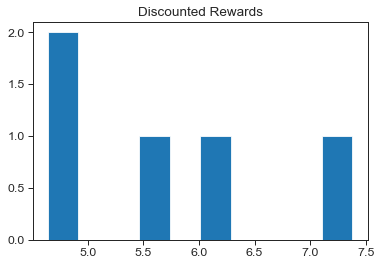

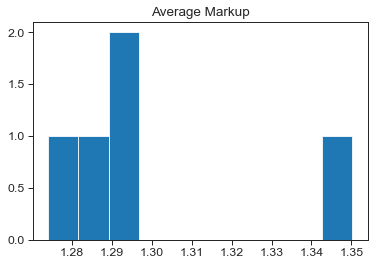

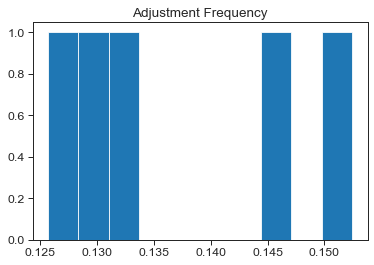

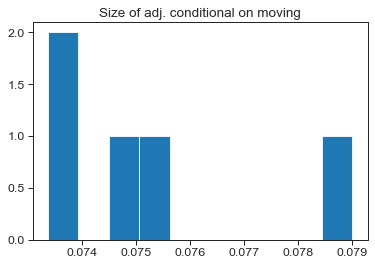

In [18]:
results = {
    "Discounted Rewards": exp_data_dict["rewards"][0],
    "Average Markup": exp_data_dict["mu_ij"][0],
    "Adjustment Frequency": exp_data_dict["freq_p_adj"][0],
    "Size of adj. conditional on moving": exp_data_dict["size_adj"][0],
}
print(results)
if PLOT_HIST:
    for i, x in results.items():
        plt.hist(x)
        plt.title(i)
        plt.savefig(
            OUTPUT_PATH_FIGURES + "hist_" + f"{i}" + "_" + exp_names[0] + ".jpg"
        )
        plt.show()
        plt.close()

In [ ]:
""" Step 1: Plot progress during learning run """

if PLOT_PROGRESS == True:
    # Big plot

    data_progress_df = pd.read_csv(progress_csv_dirs[0])
    max_rewards = abs(data_progress_df["discounted_rewards_trial_0"].max())
    exp_data_simul_dict["max rewards"].append(max_rewards)
    exp_data_simul_dict["time to peak"].append(0)

    for metric in [
        "discounted_rewards",
        "mu_ij_mean",
        "freq_p_adj_mean",
        "size_adj_mean",
    ]:
        for trial_metric in [
            metric + f"_trial_{i}" for i in range(len(results["discounted_rewards"]))
        ]:
            learning_plot = sn.lineplot(
                data=data_progress_df, y=trial_metric, x="episodes_total"
            )

        learning_plot = learning_plot.get_figure()
        plt.ylabel(metric)
        plt.xlabel("Timesteps (thousands)")
        plt.xlim([0, 500])
        learning_plot.savefig(
            OUTPUT_PATH_FIGURES + "progress_" + metric + "_" + exp_names[-1] + ".png"
        )
        plt.show()
        plt.close()

In [5]:

""" Step 2: Congif env, Restore RL policy """

""" Step 2.0: replicate original environemnt and config """
# environment config
env_config = {
    "horizon": ENV_HORIZON,
    "n_inds": 200,
    "n_firms": 2,
    "eval_mode": False,
    "analysis_mode": False,
    "seed_eval": 50000,
    "seed_analisys": 3000,
    "no_agg": False,
    "markup_min": 1,
    "markup_max": 2,
    "markup_star": 1.3,
    "final_stage": 12,
    "rew_mean": 0,
    "rew_std": 1,
    "parameters": {
        "beta": BETA,
        "log_g_bar": 0.0021,
        "rho_g": 0.61,
        "sigma_g": 0.0019,
        "theta": 1.5,
        "eta": 10.5,
        "menu_cost": 0.17,
        "sigma_z": 0.038,
    },
}


env_config_eval = env_config.copy()
env_config_eval["eval_mode"] = False
# env_config_eval["horizon"] = ENV_HORIZON

env_config_noagg = env_config_eval.copy()
env_config_noagg["no_agg"] = True


# We instantiate the environment to extract information.
env = MonPolicyFinite(env_config_eval)
config_algo = {
    "gamma": BETA,
    "env": env_label,
    "env_config": env_config_eval,
    "horizon": ENV_HORIZON,
    "explore": True,
    "framework": "torch",
    "multiagent": {
        "policies": {
            "firm_even": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ),
            "firm_odd": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ),
        },
        "policy_mapping_fn": (
            lambda agent_id: "firm_even" if agent_id % 2 == 0 else "firm_odd"
        ),
    },
}




/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
""" Step 3.0: replicate original environemnt and config """
shutdown()
init(
    log_to_driver=False,
)
# We instantiate the environment to extract information.
""" CHANGE HERE """
env = MonPolicyFinite(env_config_eval)
env_noagg = MonPolicyFinite(env_config_noagg)

""" Step 3.1: restore trainer """

simul_results_dict = {
    "discounted_rewards": [],
    "mu_ij": [],
    "mu_ij_final": [],
    "freq_p_adj": [],
    "size_adj": [],
    "log_c_mean": [],
    "log_c_std": [],
    "IRs": [],
    "cum_IRs": [],
}

# restore the trainer

trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)

""" Simulate an episode (SIMUL_PERIODS timesteps) """
rew_list = []
mu_ij_list = []
mu_ij_final_list = []
freq_p_adj_list = []
size_adj_list = []
log_c_list = []
epsilon_g_list = []
rew_list_noagg = []
mu_ij_list_noagg = []
freq_p_adj_list_noagg = []
size_adj_list_noagg = []
log_c_list_noagg = []
log_c_filt_list = []

# loop with agg
obs = env.reset()
obs_noagg = env_noagg.reset()
for t in range(SIMUL_PERIODS):
    if t % env.horizon == 0:
        print("time:", t)
        obs = env.reset()
        obs_noagg = env_noagg.reset()
    action = {
        i: trained_trainer.compute_action(obs[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs[i], policy_id="firm_odd")
        for i in range(env.n_agents)
    }
    action_noagg = {
        i: trained_trainer.compute_action(obs_noagg[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs_noagg[i], policy_id="firm_odd")
        for i in range(env.n_agents)
    }

    obs, rew, done, info = env.step(action)
    obs_noagg, rew_noagg, done_noagg, info_noagg = env_noagg.step(action_noagg)
    rew_list.append(info[0]["mean_profits"])
    if t % env.horizon < 48:
        mu_ij_list.append(info[0]["mean_mu_ij"])
        freq_p_adj_list.append(info[0]["move_freq"])
        size_adj_list.append(info[0]["mean_p_change"])
        log_c_list.append(info[0]["log_c"])
        epsilon_g_list.append(env.epsilon_g)
        rew_list_noagg.append(info_noagg[0]["mean_profits"])
        mu_ij_list_noagg.append(info_noagg[0]["mean_mu_ij"])
        freq_p_adj_list_noagg.append(info_noagg[0]["move_freq"])
        size_adj_list_noagg.append(info_noagg[0]["mean_p_change"])
        log_c_list_noagg.append(info_noagg[0]["log_c"])
        log_c_filt_list.append(log_c_list[-1] - log_c_list_noagg[-1])
    if t % env.horizon > 59:
        mu_ij_final_list.append(info[0]["mean_mu_ij"])



shutdown()

2021-10-24 13:39:49,658	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-10-24 13:39:52,128	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-10-24 13:39:56,424	INFO trainable.py:377 -- Restored on 192.168.1.202 from checkpoint: /Users/matiascovarrubias/ray_results/native_mon_policy_finite_2_firms_Oct18_v1_PPO_run/PPO_mon_policy_finite_6310c_00000_0_2021-10-18_22-08-01/checkpoint_004000/checkpoint-4000
2021-10-24 13:39:56,426	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 4000, '_timesteps_total': None, '_time_total': 33352.36966562271, '_episodes_total': 4000}


time: 0
time: 72
time: 144
time: 216
time: 288
time: 360
time: 432
time: 504
time: 576
time: 648
time: 720
time: 792
time: 864
time: 936
time: 1008


log_c_filt: [0.004967553715869821, 0.006809706305585972, 0.013355532097961559, 0.021291744150555708, 0.021959548398154977, 0.0216627494322974, 0.01593201749635975, 0.010097175309896289, 0.008827527566198395, 0.006197179585235024, -1.6267246983892036e-06, -0.0068493325958637885, -0.012408763650448379, -0.022589909596266833, -0.0277802605736856, -0.034707253722718295, -0.027386098759913047, -0.02277520840218536, -0.01882786126095523, -0.012871304213542739, -0.019085414318023047, -0.02742448568989886, -0.039881020501799286, -0.034810947795401004, -0.03306005495191258, -0.023627034924447593, -0.030580811337894892, -0.028906803789687158, -0.020127309636110008, -0.012051168796337691, -0.01252081982685263, -0.003423918453530961, 0.008792348154221363, 0.024349104151950296, 0.028254763819658052, 0.028519227729159102, 0.03840566235187437, 0.03837001348912458, 0.0410259824951307, 0.03575919862823887, 0.03291867722033426, 0.03751431021573168, 0.029831135280834337, 0.022257037830866716, 0.016177376

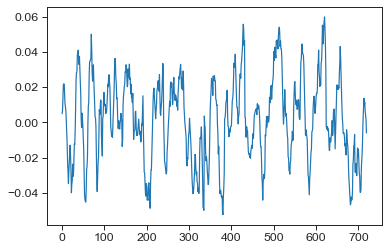

std_log_c: [0.02352740806347994, 0.02352740806347994, 0.02352740806347994, 0.02352740806347994, 0.02352740806347994, 0.02352740806347994, 0.02352740806347994, 0.02352740806347994, 0.02352740806347994] 
mu_ij: [1.342666203012908, 1.342666203012908, 1.342666203012908, 1.342666203012908, 1.342666203012908, 1.342666203012908, 1.342666203012908, 1.342666203012908, 1.342666203012908] 
freq_p_adj: [0.12457638888888888, 0.12457638888888888, 0.12457638888888888, 0.12457638888888888, 0.12457638888888888, 0.12457638888888888, 0.12457638888888888, 0.12457638888888888, 0.12457638888888888] 
size_adj: [0.08310010289241529, 0.08310010289241529, 0.08310010289241529, 0.08310010289241529, 0.08310010289241529, 0.08310010289241529, 0.08310010289241529, 0.08310010289241529, 0.08310010289241529] 
mu_ij_final: [1.3595674966346059, 1.3595674966346059, 1.3595674966346059, 1.3595674966346059, 1.3595674966346059, 1.3595674966346059, 1.3595674966346059, 1.3595674966346059, 1.3595674966346059]


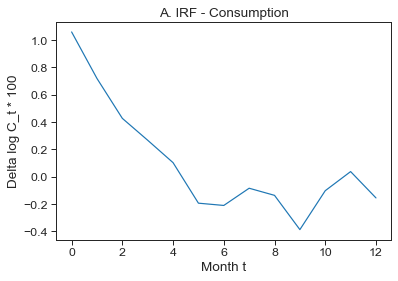

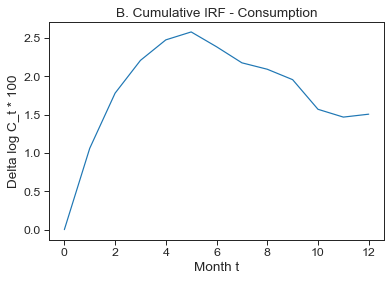

In [15]:
delta_log_c = [j - i for i, j in zip(log_c_filt_list[:-1], log_c_filt_list[1:])]
print("log_c_filt:", log_c_filt_list, "\n",
    #"delta_log_c:", delta_log_c, 
    "\n")

plt.plot(log_c_filt_list)
plt.show()
plt.close()

IRs = [0 for t in range(13)]
for t in range(0, 13):
    epsilon_g_reg = epsilon_g_list[: -(t + 1)]
    delta_log_c_reg = delta_log_c[t:]
    to_drop = []
    for i,x in enumerate(epsilon_g_list[: -(t + 1)]):
        if x<0:
            to_drop.append(i)

    epsilon_g_reg_filt = epsilon_g_reg.pop(to_drop)
    delta_log_c_reg_filt = delta_log_c_reg.pop(to_drop)
    reg = linregress(delta_log_c_reg, epsilon_g_reg)
    IRs[t] = reg[0] * env.params["sigma_g"] * 10
cum_IRs = [np.sum(IRs[:t]) for t in range(13)]


simul_results_dict["discounted_rewards"].append(process_rewards(rew_list, BETA))
simul_results_dict["mu_ij"].append(np.mean(mu_ij_list))
simul_results_dict["mu_ij_final"].append(np.mean(mu_ij_final_list))
simul_results_dict["freq_p_adj"].append(np.mean(freq_p_adj_list))
simul_results_dict["size_adj"].append(np.mean(size_adj_list))
simul_results_dict["log_c_mean"].append(np.mean(log_c_list))
simul_results_dict["log_c_std"].append(np.std(log_c_filt_list))
simul_results_dict["IRs"].append(IRs)
simul_results_dict["cum_IRs"].append(cum_IRs)

print(
    "std_log_c:",
    simul_results_dict["log_c_std"],
    "\n" + "mu_ij:",
    simul_results_dict["mu_ij"],
    "\n" + "freq_p_adj:",
    simul_results_dict["freq_p_adj"],
    "\n" + "size_adj:",
    simul_results_dict["size_adj"],
    "\n" + "mu_ij_final:",
    simul_results_dict["mu_ij_final"],
)

""" Plot IRs """
x = [i for i in range(13)]
IRs = simul_results_dict["IRs"][-1]
plt.plot(x, IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100")
plt.xlabel("Month t")
plt.title("A. IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()

cumIRs = simul_results_dict["cum_IRs"][-1]
plt.plot(x, cum_IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100")
plt.xlabel("Month t")
plt.title("B. Cumulative IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "cum_IRs_" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()


